In [1]:
#The training batches contain the remaining images in random order
# using CIFAR100 image dataset
#Step 1: Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras.layers import Conv2D

Using TensorFlow backend.


In [2]:
#Step 2: In this step we Load the dataset
# Use the code below to load the CIFAR100 dataset
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')



#selecting a single class images
#The number was randomly chosen and any number
#between 1 to 10 can be chosen

x = x_train[y_train.flatten() == 8]

In [3]:
#Step 3: We Define parameters to be used in later processes
#let Define the input shape using the code below
image_shape = (32, 32, 3)

latent_dimensions = 100

In [4]:
#:Step 4: We Define a utility function to build the our image Generator

def build_generator(): 
  
        model = Sequential() 
  
        #Let try and Build the input layer 
        model.add(Dense(128 * 8 * 8, activation="relu", 
                        input_dim=latent_dimensions)) 
        model.add(Reshape((8, 8, 128))) 
          
        model.add(UpSampling2D()) 
          
        model.add(Conv2D(128, kernel_size=3, padding="same")) 
        model.add(BatchNormalization(momentum=0.78)) 
        model.add(Activation("relu")) 
          
        model.add(UpSampling2D()) 
          
        model.add(Conv2D(64, kernel_size=3, padding="same")) 
        model.add(BatchNormalization(momentum=0.78)) 
        model.add(Activation("relu")) 
          
        model.add(Conv2D(3, kernel_size=3, padding="same")) 
        model.add(Activation("tanh")) 
  
  
        #Let Generate the output image with this code 
        noise = Input(shape=(latent_dimensions,)) 
        image = model(noise) 
  
        return Model(noise, image)

In [5]:
#Step 5: We now Define a utility function to build a Discriminator

def build_discriminator():
    
    #let Build the convolutional layers
    #then we classify whether an image is real or fake
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.82))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.82))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))
    
    #We have to Build the output using the code below
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    
    image = Input(shape=image_shape)
    validity = model(image)
    
    return Model(image, validity)

In [6]:
#Step 6: Here we define a utility function to display the generated images

def display_images(): 
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dimensions)) 
        generated_images = generator.predict(noise) 
  
        #Let also scale the generated images 
        generated_images = 0.5 * generated_images + 0.5
  
        fig, axs = plt.subplots(r, c) 
        count = 0
        for i in range(r): 
            for j in range(c): 
                axs[i,j].imshow(generated_images[count, :,:,]) 
                axs[i,j].axis('off') 
                count += 1
        plt.show() 
        plt.close()

In [7]:
#Step 7: We have to build our Generative Adversarial Network (GAN)
# Building and compiling the discriminator 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.0002,0.5), 
                    metrics=['accuracy']) 
  
#We will make the Discriminator untrainable 
#so that the generator can learn from fixed gradient 
discriminator.trainable = False
  
# Than build the generator 
generator = build_generator() 
  
#We also define the input for the generator 
#and generating the images 
z = Input(shape=(latent_dimensions,)) 
image = generator(z) 
  
  
#Check the validity of the generated image 
valid = discriminator(image) 
  
#Define the combined model of the Generator and the Discriminator 
combined_network = Model(z, valid) 
combined_network.compile(loss='binary_crossentropy', 
                         optimizer=Adam(0.0002,0.5))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


C:\Users\boama\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


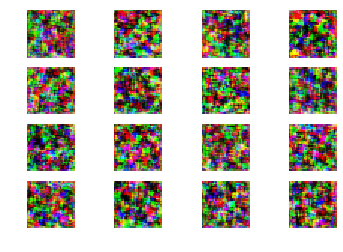

In [8]:
#Step 8: Let Train the network from here
num_epochs=150
batch_size=32
display_interval=2500
losses=[] 
  
#Normalize the input 
x_train = (x_train / 127.5) - 1.
          
  
#Define the Adversarial ground truths 
valid = np.ones((batch_size, 1)) 
  
#Add some noise to it 
valid += 0.05 * np.random.random(valid.shape) 
fake = np.zeros((batch_size, 1)) 
fake += 0.05 * np.random.random(fake.shape) 
  
for epoch in range(num_epochs): 
              
            #Train the Discriminator from here 
              
            #Sample a random half of the images 
            index = np.random.randint(0, x_train.shape[0], batch_size) 
            images = x_train[index] 
  
            #Sample the noise and generate a batch of new images here 
            noise = np.random.normal(0, 1, (batch_size, latent_dimensions)) 
            generated_images = generator.predict(noise) 
              
  
            #;et train the discriminator to detect more accurately 
            #whether a generated image is real or fake 
            discm_loss_real = discriminator.train_on_batch(images, valid) 
            discm_loss_fake = discriminator.train_on_batch(generated_images, fake) 
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake) 
              
            #Training the Generator 
  
            #Training the generator to generate images 
            #which pass the authenticity test 
            genr_loss = combined_network.train_on_batch(noise, valid) 
              
            #Tracking the progress                 
            if epoch % display_interval == 0: 
                 display_images()

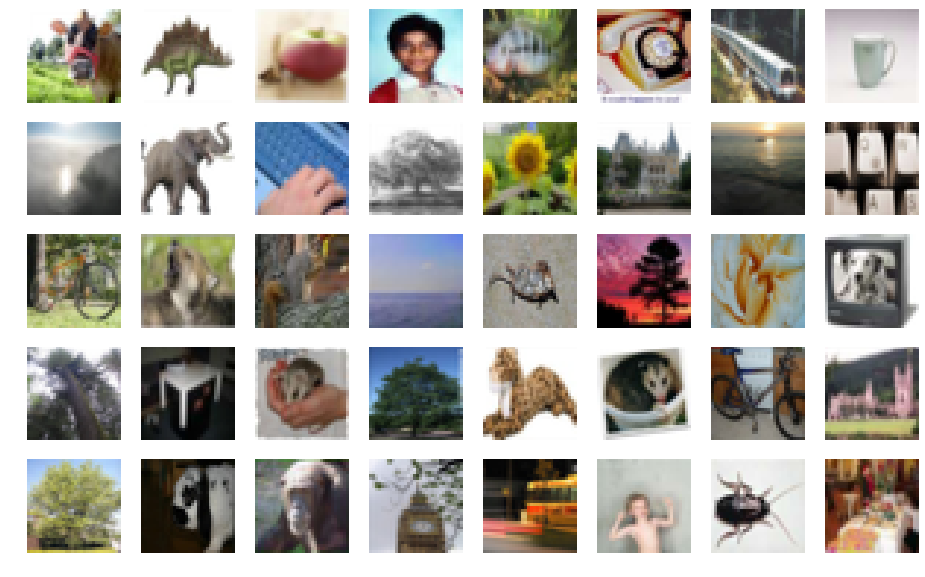

In [9]:
#Step 8: Let now evaluating the performance of our work so far
#Plott some of the original images with the code below  
s=x_train[:40] 
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10)) 
for i, image in enumerate(s): 
    ax[i//8, i%8].imshow(image) 
    ax[i//8, i%8].axis('off') 
          
plt.show()

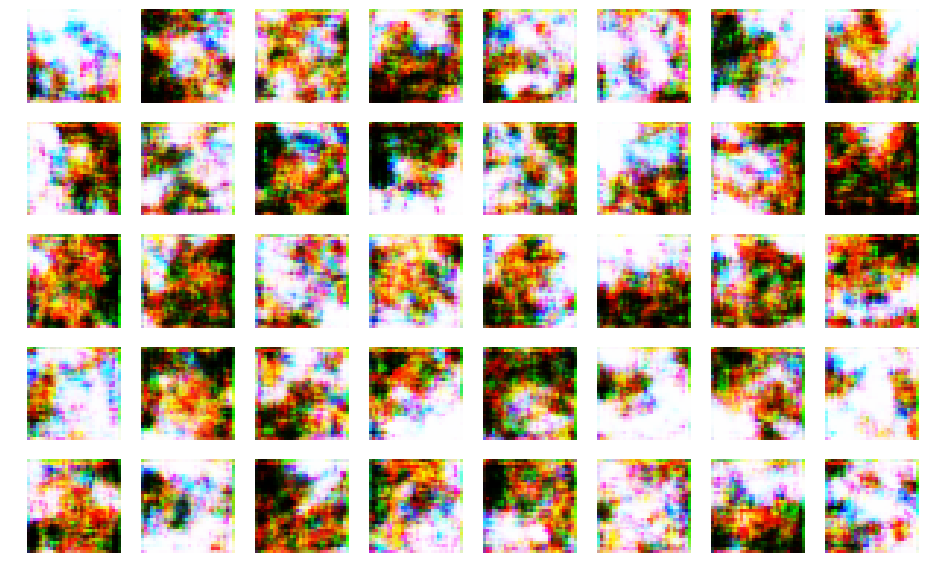

In [10]:
#Plot some of the last batch of generated images here 
noise = np.random.normal(size=(40, latent_dimensions)) 
generated_images = generator.predict(noise) 
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10)) 
for i, image in enumerate(generated_images): 
    ax[i//8, i%8].imshow(image) 
    ax[i//8, i%8].axis('off') 
    
#The performance of the network will be evaluated by 
#comparing the images generated on the last epoch to the 
#original images visually.
          
plt.show()

In [ ]:
#The performance of the network will be evaluated by 
#comparing the images generated on the last epoch to the 
#original images visually.